In [29]:
import os
import numpy as np
from astropy.io import ascii
from scipy.interpolate import interp1d
import xidplus
temps=os.listdir('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/')

Generate Redshift Grid and convert to denominator for flux conversion (e.g. $4 \pi D_l^2)$

In [30]:
red=np.arange(0,8,0.01)
red[0]=0.000001
from astropy.cosmology import Planck13
import astropy.units as u
div=(4.0*np.pi * np.square(Planck13.luminosity_distance(red).cgs))
div=div.value

Get appropriate filters

In [31]:
from xidplus import filters
filter=filters.FilterFile(file=xidplus.__path__[0]+'/../test_files/filters.res')
SPIRE_250=filter.filters[215]
SPIRE_350=filter.filters[216]
SPIRE_500=filter.filters[217]
MIPS_24=filter.filters[201]
bands=[SPIRE_250,SPIRE_350,SPIRE_500,MIPS_24]
eff_lam=[250.0,350.0,500.0,24.0]

In [43]:
SEDs=np.empty((len(temps),len(bands),red.size))
for i in range(0,len(temps)):
    template=ascii.read('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/'+temps[i])
    flux=template['col2']*((template['col1']/1E4)**2)/3E14
    wave=template['col1']/1E4

    for z in range(0,red.size):
        sed=interp1d((red[z]+1.0)*wave, flux)
        for b in range(0,len(bands)):
            SEDs[i,b,z]=1E30*3.826E33*(1.0+red[z])*filters.fnu_filt(sed(bands[b].wavelength/1E4),3E8/(bands[b].wavelength/1E10),bands[b].transmission,3E8/(eff_lam[b]*1E-6),sed(eff_lam[b]))/div[z]
        

(0.0001, 100.0)

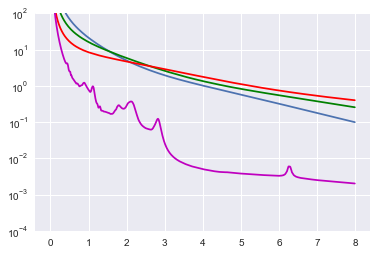

In [48]:
import pylab as plt
%matplotlib inline
plt.semilogy(red,SEDs[0,0,:]*np.power(10.0,12))
plt.semilogy(red,SEDs[0,1,:]*np.power(10.0,12),c='g')
plt.semilogy(red,SEDs[0,2,:]*np.power(10.0,12),c='r')
plt.semilogy(red,SEDs[0,3,:]*np.power(10.0,12),c='m')

plt.ylim(1E-4,1E2)